<a href="https://colab.research.google.com/github/ben45123/AWS-Lambda-Research/blob/main/ProblemSet09/Probelm_set_09_CNN_practical_considerations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part the of Dr. Christoforos Christoforou's course materials. You may not, nor may you knowingly allow others to reproduce or distribute lecture notes, course materials or any of their derivatives without the instructor's express written consent.

## Problem Set 09: Practical Consideration in CNN

For this problem set, you are expected to load an external dataset, and build a convolutional neural network that classifies images of Cat and Dogs. You are expected to implement the network based on the practical considerations outlined in the corresponding lecture. REview the video lecture of this course to complete the assignment. You wull need the following libraries to complete this probelem set.

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPooling2D,
                                     BatchNormalization, Activation, Flatten,
                                     Input, Reshape, MaxPooling1D)
from tensorflow.keras.models import Model, load_model
from PIL import Image

## Download an extenral dataset
For this problem set you are expected to download an external dataset, and build a

In [2]:
# Optional remove dataset, if previously loaded in colab.
!curl -L -o /content/dog-and-cat-dataset.zip https://www.kaggle.com/api/v1/datasets/download/bhavikjikadara/dog-and-cat-classification-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  775M  100  775M    0     0  27.7M      0  0:00:27  0:00:27 --:--:-- 30.8M


In [ ]:
!unzip /content/dog-and-cat-dataset.zip

Often, you will have to work with datasets that include **corrupted images**. It is important that before you use a dataset to train your model you sanetize and remove corrupted images. The code below illustrates one way to do that. In particular, it iterates over all images in the specific dataset (i.e. Cats and Dogs datasdet) and if the images are corrupt, it removes them from the dataset. The method `is_valid_jpg` checks if a particular image is corrupted or not, while the `remove_corrapted_images_from_folder` method removes all corrupted images from the dataset.  


In [4]:
from PIL import Image

def is_valid_jpg(filename):
  try:
    i=Image.open(filename)
    return i.format =='JPEG'
  except IOError:
    return False

def remove_corrupted_images_from_folder(cdir, verbose=False):
  total=0
  counter = 0
  for subdir, dirs, files in os.walk(cdir):
      for filename in files:
          filepath = subdir + os.sep + filename
          if filepath.endswith(".jpg") or filepath.endswith(".png"):
            total += 1
            if not is_valid_jpg(filepath):
              counter +=1
              os.remove(filepath)
              if (verbose):
                print(f"--Removed file ${filepath}")
  print(f"{counter} jpeg files removed out of {total} in folder {cdir}")

In [ ]:
# Define directories
train_cat_dir = "/content/PetImages/Cat"
train_dog_dir = "/content/PetImages/Dog"

# Remove corrupted images in training directories
remove_corrupted_images_from_folder(train_cat_dir, verbose=True)
remove_corrupted_images_from_folder(train_dog_dir, verbose=True)

## Exercise

Create a convolutional neural network to classify images in the above dataset to either Cat or Dogs. Your solution should comply with the following requirements:

* Build computational blocks that include a sqeunce of `Covolution Layer`-> `BatchNormailization` -> `Activation` -> `Max Pooling` -> `Dropout Layer`.
* Build computational blocks that include a sequence of `Dense Layer`-> `BatchNormailization Layer` -> `Activation function` -> `Max Pooling`.
* Build a model that utilizes the above computational blocks. You can use additional layers if you like.
* Create a manual split of the dataset set into a `Training Set` and `Validation Set`. You are expected to store the training and validation set into separate filders so they can be loaded using the `ImageDataGenerator` class.
* Prepare `ImageDataGenerator` objects to load batches of training and validation images from the corresponding folders. Add an image augmentation layer and make sure you use the `flow_from_directory` method.
* Train the model using `EarlyStopping` and `ModelCheckpoint` callback functions.
* Report validation performance on each epoch.
* Fine-tune your model to achieve classification performance above 80%.
* Save the best model.
* Load the best model and display the model structure (i.e. using the `model.summary()` method.


Use as many cells as you need to complete the problem set.


In [6]:

# Use as many cells as you need.
#

base_dir = '/content/sample_data/cats_dogs_small'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Create directories
for subset in [train_dir, valid_dir]:
    for category in ['Cat', 'Dog']:
        os.makedirs(os.path.join(subset, category), exist_ok=True)

# For each category, shuffle and split (80% train, 20% validation)
split_ratio = 0.8
for category in ['Cat', 'Dog']:
    src_dir = os.path.join('/content/PetImages', category)
    files = os.listdir(src_dir)
    random.shuffle(files)
    split_index = int(len(files) * split_ratio)
    train_files = files[:split_index]
    valid_files = files[split_index:]

    for file in train_files:
        src = os.path.join(src_dir, file)
        dst = os.path.join(train_dir, category, file)
        shutil.copyfile(src, dst)

    for file in valid_files:
        src = os.path.join(src_dir, file)
        dst = os.path.join(valid_dir, category, file)
        shutil.copyfile(src, dst)

print("Dataset splitting completed.")

Dataset splitting completed.


In [7]:
image_size = (64, 64)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 19815 images belonging to 2 classes.
Found 4954 images belonging to 2 classes.


In [8]:
def conv_block(x, filters, kernel_size=(3,3), pool_size=(2,2), dropout_rate=0.25):
    """Convolutional block: Conv2D -> BatchNorm -> Activation -> MaxPooling -> Dropout"""
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(dropout_rate)(x)
    return x

def dense_block(x, units, dropout_rate=0.5):
    """
    Dense block: Dense -> BatchNorm -> Activation -> (simulate) MaxPooling -> Dropout.
    Note: Dense layers are typically not pooled. Here we reshape to use MaxPooling1D.
    """
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Reshape to (units, 1) to enable pooling over the feature dimension
    x = Reshape((units, 1))(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    return x

In [9]:
input_shape = (64, 64, 3)
inputs = Input(shape=input_shape)

x = conv_block(inputs, 32, kernel_size=(3,3), pool_size=(2,2), dropout_rate=0.25)
x = conv_block(x, 64, kernel_size=(3,3), pool_size=(2,2), dropout_rate=0.25)
x = conv_block(x, 128, kernel_size=(3,3), pool_size=(2,2), dropout_rate=0.25)

# Flatten the output
x = Flatten()(x)

# Use a dense block
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Final output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,143,489 (4.36 MB)

 Trainable params: 1,142,785 (4.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [10]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/best_model.h5', monitor='val_accuracy', save_best_only=True)
]

In [11]:
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=100, # Use 100 steps per epoch
    validation_data=validation_generator,
    validation_steps=25, # Use 25 validation steps
    epochs=epochs,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.5608 - loss: 0.8245

100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.5611 - loss: 0.8238 - val_accuracy: 0.4931 - val_loss: 0.9655
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6455 - loss: 0.6643 - val_accuracy: 0.4881 - val_loss: 0.9751
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.6418 - loss: 0.6411

100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6419 - loss: 0.6411 - val_accuracy: 0.4969 - val_loss: 0.9139
Epoch 4/10
 10/100 ━━━━━━━━━━━━━━━━━━━━ 1:29 995ms/step - accuracy: 0.6554 - loss: 0.6169

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.6449 - loss: 0.6229 - val_accuracy: 0.5169 - val_loss: 0.8248
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6554 - loss: 0.6273

100/100 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6554 - loss: 0.6273 - val_accuracy: 0.5688 - val_loss: 0.7568
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.6669 - loss: 0.6259

100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6669 - loss: 0.6257 - val_accuracy: 0.5906 - val_loss: 0.7510
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6809 - loss: 0.5978

100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6808 - loss: 0.5978 - val_accuracy: 0.7075 - val_loss: 0.5542
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.6725 - loss: 0.5947 - val_accuracy: 0.6737 - val_loss: 0.5860
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 0.6905 - loss: 0.5831

100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6905 - loss: 0.5831 - val_accuracy: 0.7375 - val_loss: 0.5199
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7036 - loss: 0.5722 - val_accuracy: 0.7256 - val_loss: 0.5247


In [12]:
best_model = load_model('/content/best_model.h5')
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,143,491 (4.36 MB)

 Trainable params: 1,142,785 (4.36 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2 (12.00 B)

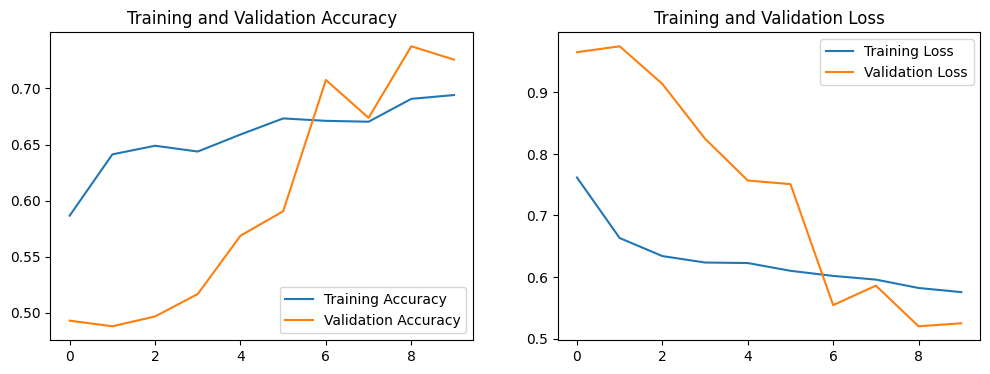

In [13]:
# Retrieve metrics from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot training and validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Copyright Statement: Copyright © 2020 Christoforou. The materials provided by the instructor of this course, including this notebook, are for the use of the students enrolled in the course. Materials are presented in an educational context for personal use and study and should not be shared, distributed, disseminated or sold in print — or digitally — outside the course without permission. You may not, nor may you knowingly allow others to reproduce or distribute lecture notes, course materials as well as any of their derivatives without the instructor's express written consent.